In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# dependencies
import os
import sys
import numpy as np
import torchvision.models as models
import torch
from torchvision import transforms
import numpy as np
from skimage import io, transform, color, metrics
import imageio
import matplotlib.pyplot as plt

In [4]:
# Check if a GPU is available and set the device
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [16]:
import cv2
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
# Using two channel similarity measures

def normalized_cut(W, num_clusters):
    n = W.shape[0]
    D = np.zeros((n, n))
    for i in range(n):
        D[i, i] = np.sum(W[i, :])
    L = D - W
    inverse_sqrt_D = np.linalg.inv(np.sqrt(D))
    L = inverse_sqrt_D@L@inverse_sqrt_D
    eigenvalues, eigenvectors = la.eigh(L)
    idx = np.argsort(eigenvalues)[:num_clusters]
    eigenvectors = eigenvectors[:, idx]
    labels = np.zeros(n, dtype=int)
    for i in range(num_clusters):
        labels[eigenvectors[:, i] >= 0] = i
    return labels

def image_segmentation(image, num_clusters,background_color,object_color):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    width = min(90,int(image.shape[1] * 0.5))
    height = min(90,int(image.shape[0] * 0.5))
    dim = (width, height)
    gray = cv2.resize(gray,dim, fx=0.5, fy=0.5, interpolation=cv2.INTER_LINEAR)
    
    # Reshape the image into a 2D array of pixels
    pixels = gray.reshape(-1)
    n = len(pixels)
    # Compute the similarity matrix
    W = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            d = (pixels[i] - pixels[j])**2
            W[i, j] = np.exp(-d/50)
            W[j, i] = W[i, j]
    # Perform image segmentation using the N-Cut algorithm
    labels = normalized_cut(W, num_clusters)
    # Create a new image with the segmented regions colored differently
    segments = np.zeros((gray.shape[0], gray.shape[1], 3), dtype=np.uint8)
    for i in range(num_clusters):
        idx = (labels == i)
        if(i==0):
          segments[idx.reshape(gray.shape[0], gray.shape[1])] = object_color
        else:
          segments[idx.reshape(gray.shape[0], gray.shape[1])] = background_color
    return segments

In [6]:
test_image_names = []
annotations_image_names = []
text_file_path = '/content/drive/MyDrive/AIP_A2/q2/PascalVOC/test/test.txt'
with open(text_file_path, 'r') as file:
    for line in file:
        # Remove any leading or trailing whitespace from the line
        line = line.strip()
        # Add the '.png' extension to the image name and append it to the list
        test_image_names.append(line + '.jpg')
        annotations_image_names.append(line + '.png')

In [7]:
# number of classes
num_classes = 21

color2index = {
    (0,   0,   0)   : 0,   # background
    (128, 0,   0)   : 1,   # aeroplane
    (0,   128, 0)   : 2,   # bicycle
    (128, 128, 0)   : 3,   # bird
    (0,   0,   128) : 4,   # boat
    (128, 0,   128) : 5,   # bottle
    (0,   128, 128) : 6,   # bus
    (128, 128, 128) : 7,   # car
    (64,  0,   0)   : 8,   # cat
    (192, 0,   0)   : 9,   # chair
    (64,  128, 0)   : 10,  # cow
    (192, 128, 0)   : 11,  # dining table
    (64,  0,   128) : 12,  # dog
    (192, 0,   128) : 13,  # horse
    (64,  128, 128) : 14,  # motorbike
    (192, 128, 128) : 15,  # person
    (0,   64,  0)   : 16,  # potted plant
    (128, 64,  0)   : 17,  # sheep
    (0,   192, 0)   : 18,  # sofa
    (128, 192, 0)   : 19,  # train
    (0,   64,  128) : 20,  # tv/monitor
}


# convert segmented rgb image (3D) to class label mask (2D)
def rgb2mask(img):

    assert len(img.shape) == 3
    height, width, ch = img.shape
    assert ch == 3

    W = np.power(256, [[0],[1],[2]])

    img_id = img.dot(W).squeeze(-1) 
    values = np.unique(img_id)

    mask = np.zeros(img_id.shape)

    for i, c in enumerate(values):
        try:
            mask[img_id==c] = color2index[tuple(img[img_id==c][0])] 
        except:
            pass
    return mask

In [8]:
# Accuracy function
def pixelwise_accuracy(predicted_masks, gt_masks):
    acc = np.zeros(len(predicted_masks))
    for i in range(len(predicted_masks)):
      num_correct = np.sum(predicted_masks[i] == gt_masks[i])
      num_pixels = predicted_masks[i].size
      accuracy = num_correct / num_pixels
      acc[i] = accuracy
    
    return np.mean(acc)

In [9]:
# Mean IOU function
def mean_iou(predicted_masks, gt_masks):
    total_iou = np.zeros(len(predicted_masks))

    for i in range(len(predicted_masks)):
      
      temp = predicted_masks[i]
      
      # Initialize variables to store the per-class intersection and union
      intersection = []
      union = []

      # Calculate the intersection and union for each class
      for c in range(num_classes):
          # Get binary masks for the current class in the predicted and ground truth masks
          pred_class = (predicted_masks[i] == c)
          gt_class = (gt_masks[i] == c)
          
          # Calculate the intersection and union of the binary masks
          temp_union = np.logical_or(pred_class, gt_class).sum()
          if(temp_union!=0):
            intersection.append(np.logical_and(pred_class, gt_class).sum())
            union.append(temp_union) 
          
      # Calculate the IoU for each class and the overall mean IoU
      iou_per_class = [i / j for i, j in zip(intersection, union)]
      
      total_iou[i] = sum(iou_per_class)/len(iou_per_class)
      
    return np.mean(total_iou)

In [10]:
def FCN_ResNet50(model):
  # Loading model to device (or GPU)
  model.to(device)
  # Set the model to evaluation mode
  model.eval()

  
  # Transform
  composed_transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Resize(256),
  ])

  # Define the path to the test images and their corresponding ground truth segmentation masks
  test_images_path = "/content/drive/MyDrive/AIP_A2/q2/PascalVOC/test/Images/"
  test_masks_path = "/content/drive/MyDrive/AIP_A2/q2/PascalVOC/test/Annotations/"

  # Initialize lists to store the predicted segmentation masks and ground truth segmentation masks
  predicted_masks = []
  gt_masks = []
  
  # Loop over the test image names
  for original_image,segmented_image in zip(test_image_names,annotations_image_names):
      
      # Load the test image and ground truth segmentation mask
      image = io.imread(test_images_path + original_image)

      gt_mask = imageio.imread(test_masks_path + segmented_image, pilmode='RGB')
      gt_mask = np.asarray(gt_mask)

      
      # Apply the transformation to the test image and ground truth (not necessary to apply any transformation on both)
      image = composed_transform(image)
      gt_mask = composed_transform(gt_mask)
      
      # convert tensor to numpy and coz transform convert the range 0-255 to 0-1, getting the original values back
      gt_mask = gt_mask.numpy().transpose((1, 2, 0))
      gt_mask = gt_mask*255
      gt_mask = np.rint(gt_mask)

      
      # Add a batch dimension to the image tensor (model expects batch dimension, even if it is 1)
      image = image.unsqueeze(0)
      image = image.to(device)

      # Pass the preprocessed test image through the model to obtain the predicted segmentation mask
      with torch.no_grad():
          output = model(image)["out"]
      
      # If we don't load the results back to cpu we will exhaust our GPU
      image = image.cpu()
      output = output.cpu()

      # Convert the predicted segmentation mask to an integer numpy array
      predicted_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy().astype(np.int32)
      
      # convert segmented rgb image (3D) to class label mask (2D)
      gt_mask = rgb2mask(gt_mask)

      # Append the predicted segmentation mask and ground truth segmentation mask to their respective lists
      predicted_masks.append(predicted_mask)
      gt_masks.append(gt_mask)
  model.cpu()
  return pixelwise_accuracy(predicted_masks,gt_masks),mean_iou(predicted_masks, gt_masks),model


In [11]:
# Load the pre-trained ResNet50-based FCN model
model = models.segmentation.fcn_resnet50(pretrained=True, progress=True)
acc,iou,model = FCN_ResNet50(model)
print("For Test Images:\nAccuracy: ",acc,"\nMean IOU: ",iou)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth


  0%|          | 0.00/135M [00:00<?, ?B/s]

For Test Images:
Accuracy:  0.8886965896608796 
Mean IOU:  0.5699113214543341


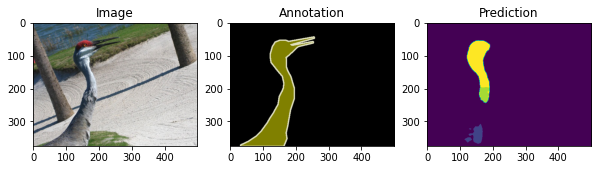

In [12]:
model.cpu()
test_images_path = "/content/drive/MyDrive/AIP_A2/q2/PascalVOC/test/Images/"
test_masks_path = "/content/drive/MyDrive/AIP_A2/q2/PascalVOC/test/Annotations/"
image_name = test_image_names[0]
annotation_name = annotations_image_names[0]
image = io.imread(os.path.join(test_images_path,image_name))
annotation = imageio.imread(os.path.join(test_masks_path,annotation_name), pilmode='RGB')
annotation = np.asarray(annotation)



fig, ax = plt.subplots(1, 3, figsize=(10, 5))

# Display the image
ax[0].imshow(image)
ax[0].set_title('Image')

# Display the annotation
ax[1].imshow(annotation)
ax[1].set_title('Annotation')


composed_transform = transforms.Compose([
    transforms.ToTensor(),
])

image = composed_transform(image)
image = image.unsqueeze(0)
prediction = model(image)["out"]
prediction = torch.argmax(prediction, dim=1).squeeze().cpu().numpy().astype(np.int32)

# Display the Prediction
ax[2].imshow(prediction)
ax[2].set_title('Prediction')

plt.show()

Question 2 part 3: Comparison between NCut and FCN

<ipython-input-16-3453232f1fcd>:38: RuntimeWarning: overflow encountered in ubyte_scalars
  d = (pixels[i] - pixels[j])**2


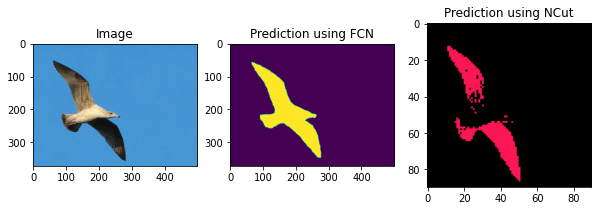

In [17]:
path_to_image4 = '/content/drive/MyDrive/AIP_A2/test4.jpg'
image4 = io.imread(path_to_image4)

fig, ax = plt.subplots(1, 3, figsize=(10, 5))

# Display the image
ax[0].imshow(image4)
ax[0].set_title('Image')

# Display the annotation
composed_transform = transforms.Compose([
    transforms.ToTensor(),
])

image4 = composed_transform(image4)
image4 = image4.unsqueeze(0)
FCN_prediction4 = model(image4)["out"]
FCN_prediction4 = torch.argmax(FCN_prediction4, dim=1).squeeze().cpu().numpy().astype(np.int32)
ax[1].imshow(FCN_prediction4)
ax[1].set_title('Prediction using FCN')
image4 = cv2.imread('/content/drive/MyDrive/AIP_A2/test4.jpg')
Ncut_prediction4 = image_segmentation(image4,2,np.array([0,0,0]),np.array([251,23,83]))

# Display the Prediction
ax[2].imshow(Ncut_prediction4)
ax[2].set_title('Prediction using NCut')

plt.show()

<ipython-input-16-3453232f1fcd>:38: RuntimeWarning: overflow encountered in ubyte_scalars
  d = (pixels[i] - pixels[j])**2


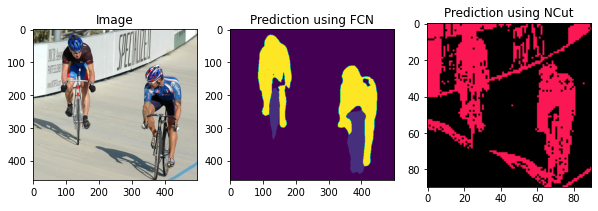

In [19]:
path_to_image5 = '/content/drive/MyDrive/AIP_A2/test5.jpg'

image5 = io.imread(path_to_image5)

fig, ax = plt.subplots(1, 3, figsize=(10, 5))

ax[0].imshow(image5)
ax[0].set_title('Image')

composed_transform = transforms.Compose([
    transforms.ToTensor(),
])

image5 = composed_transform(image5)
image5 = image5.unsqueeze(0)
FCN_prediction5 = model(image5)["out"]
FCN_prediction5 = torch.argmax(FCN_prediction5, dim=1).squeeze().cpu().numpy().astype(np.int32)
ax[1].imshow(FCN_prediction5)
ax[1].set_title('Prediction using FCN')
image5 = cv2.imread('/content/drive/MyDrive/AIP_A2/test5.jpg')
Ncut_prediction5 = image_segmentation(image5,2,np.array([0,0,0]),np.array([251,23,83]))

# Display the Prediction
ax[2].imshow(Ncut_prediction5)
ax[2].set_title('Prediction using NCut')

plt.show()